<a href="https://colab.research.google.com/github/ksetdekov/ML_light_switch/blob/time_series_modelling/exploratory_and_model_fb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
from fbprophet import Prophet
from sklearn.model_selection import train_test_split


In [ ]:
engine = create_engine('sqlite:///temperature.db')
# engine = create_engine('sqlite:////content/temperature (1).db')
data = pd.read_sql_table("timelog", engine)
data.tail()

,stamp,temp,hum,plug,heater
8295724,2021-05-26 11:54:12.172836,26.4,29.700001,1.0,0.0
8295725,2021-05-26 11:54:13.796678,26.4,29.700001,1.0,0.0
8295726,2021-05-26 11:54:15.421471,26.4,29.700001,1.0,0.0
8295727,2021-05-26 11:54:17.093325,26.4,29.700001,1.0,0.0
8295728,2021-05-26 11:54:24.352203,26.4,29.700001,1.0,0.0


In [ ]:
data['stamp'] = pd.to_datetime(data['stamp'])

# explore

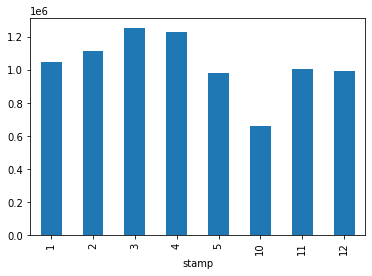

In [ ]:
%matplotlib inline
data.groupby(data['stamp'].dt.month).size().plot(kind = 'bar')

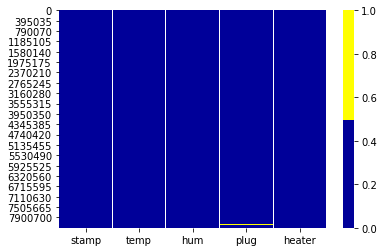

In [ ]:
cols = data.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colors = ['#000099', '#ffff00'] 
a = sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colors))

In [ ]:
data["temp"].isnull().mean()

2.4108791403383595e-07

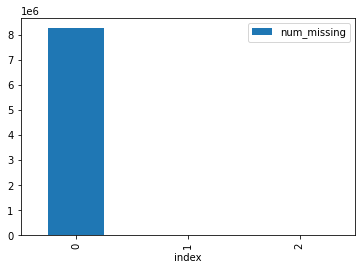

In [ ]:
# сначала создаем индикатор для признаков с пропущенными данными
for col in data.columns:
    missing = data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
#         print('created missing indicator for: {}'.format(col))
        data['{}_ismissing'.format(col)] = missing
        
# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in data.columns if 'ismissing' in col]
data['num_missing'] = data[ismissing_cols].sum(axis=1)
u = data['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index')

In [ ]:
data.num_missing.mean()

0.004060523192114882

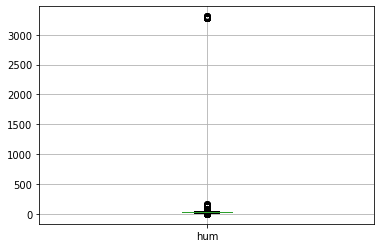

In [ ]:
data.boxplot(column=['hum'])

In [ ]:
misscount = data.isna().sum()
misscount[misscount>0]

temp          2
hum           2
plug      32653
heater     1028
dtype: int64

In [ ]:
data[data.plug_ismissing == True]

,stamp,temp,hum,plug,heater,temp_ismissing,hum_ismissing,plug_ismissing,heater_ismissing,num_missing
325,2020-10-14 15:49:06.954412,26.000000,47.000000,NaN,1.0,False,False,True,False,1
326,2020-10-14 15:49:16.351531,26.000000,48.000000,NaN,1.0,False,False,True,False,1
327,2020-10-14 15:49:25.596830,26.000000,48.000000,NaN,1.0,False,False,True,False,1
328,2020-10-14 15:49:32.347595,26.000000,48.000000,NaN,1.0,False,False,True,False,1
348,2020-10-14 15:50:44.642289,26.000000,48.000000,NaN,1.0,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...
8190128,2021-05-23 22:19:26.338102,25.299999,30.600000,NaN,0.0,False,False,True,False,1
8190129,2021-05-23 22:19:33.067454,25.299999,30.700001,NaN,0.0,False,False,True,False,1
8190130,2021-05-23 22:19:39.826101,25.299999,30.700001,NaN,0.0,False,False,True,False,1
8190131,2021-05-23 22:19:46.584291,25.299999,30.799999,NaN,0.0,False,False,True,False,1


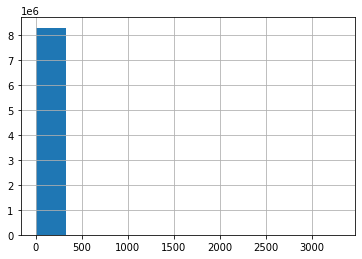

In [ ]:
data.hum.hist()

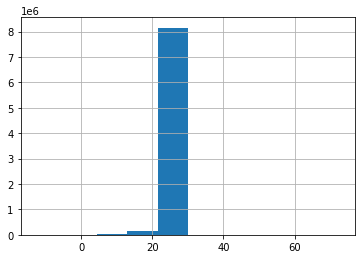

In [ ]:
data.temp.hist()

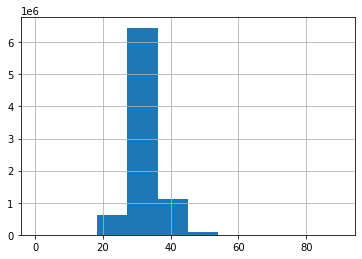

In [ ]:
data['hum'].mask(data['hum'].between(-np.inf, 0), inplace=True)
data['hum'].mask(data['hum'].between(100, np.inf), inplace=True)

data.hum.hist()

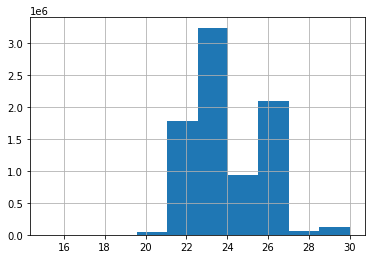

In [ ]:
data['temp'].mask(data['temp'].between(-np.inf, 15), inplace=True)
data['temp'].mask(data['temp'].between(40, np.inf), inplace=True)

data.temp.hist()

In [ ]:
data=data.dropna()
misscount = data.isna().sum()

misscount[misscount>0]

Series([], dtype: int64)

In [ ]:
y_plug = data.plug
y_heater=data.heater
data.drop(columns=['plug', 'heater'], inplace=True)

In [ ]:
data

,stamp,temp,hum,temp_ismissing,hum_ismissing,plug_ismissing,heater_ismissing,num_missing
0,2020-10-14 15:22:31.111918,25.0,51.000000,False,False,False,False,0
1,2020-10-14 15:22:32.914186,26.0,48.000000,False,False,False,False,0
2,2020-10-14 15:22:37.486081,26.0,49.000000,False,False,False,False,0
3,2020-10-14 15:22:39.234348,26.0,48.000000,False,False,False,False,0
4,2020-10-14 15:22:41.081851,26.0,49.000000,False,False,False,False,0
...,...,...,...,...,...,...,...,...
8295724,2021-05-26 11:54:12.172836,26.4,29.700001,False,False,False,False,0
8295725,2021-05-26 11:54:13.796678,26.4,29.700001,False,False,False,False,0
8295726,2021-05-26 11:54:15.421471,26.4,29.700001,False,False,False,False,0
8295727,2021-05-26 11:54:17.093325,26.4,29.700001,False,False,False,False,0


# logistic regression

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
X = data
y = y_plug
tscv = TimeSeriesSplit()
print(tscv)
for train_index, test_index in tscv.split(X):
     print("TRAIN:", train_index, "TEST:", test_index)

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [      0       1       2 ... 1374088 1374089 1374090] TEST: [1374091 1374092 1374093 ... 2748176 2748177 2748178]
TRAIN: [      0       1       2 ... 2748176 2748177 2748178] TEST: [2748179 2748180 2748181 ... 4122264 4122265 4122266]
TRAIN: [      0       1       2 ... 4122264 4122265 4122266] TEST: [4122267 4122268 4122269 ... 5496352 5496353 5496354]
TRAIN: [      0       1       2 ... 5496352 5496353 5496354] TEST: [5496355 5496356 5496357 ... 6870440 6870441 6870442]
TRAIN: [      0       1       2 ... 6870440 6870441 6870442] TEST: [6870443 6870444 6870445 ... 8244528 8244529 8244530]


# FB prophet

In [ ]:
ds=X.stamp
df=y.to_frame().join(ds)
df.columns =['y', 'ds']

In [ ]:
small_df=df.sample(frac=0.1, replace=True, random_state=1)

In [ ]:
m = Prophet()
m.fit(small_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
fig = m.plot_components(forecast)


NameError: ignored